# Part 2
This notebook contains the exploratory component and the conclusion. I.e. section 3 and 4.

---
## Exploratory component

In this notebook, we will try to do the following in order to predict if the price of a given listing is above (1) or below (0) the median of the price of all listings i Copenhagen:
1. Add proximity to metro stations, city center and tourist attractions as new features
2. Cluster the data and add the clusters as new binary variables

Our research questions will then read as follows:
* Does adding proximity to metro, city center or tourist attractions improve the prediction accuracy from part 1?
    * Given the original and the extended dataset, what features are the most important when it comes to predicting the price of a given listing? 
* Can clustering together with classification improve the prediction accuracy from part 1?

For the part on classification, we will stick to the three methods Linear Regression, Support Vector Machines (SVM) and the Random Forest classifier. These are the same methods used in part 1. We will also compare the results of our predictions with the ones obtained in the previous part. 

Content:<br/>
* 0\. Data prep
* 1\. **Exploratory component part 1:** Add proximity to metro stops, city center (indre by) and top 10 tourist attractions on TripAdvisor as a new features
    * 1.1. Metro proximity
    * 1.2. Indre by (city center) proximity
    * 1.3. Top ten tourist attraction proximity
    * 1.4. Visuals of the new attributes (scatters and histograms)
    * 1.5. Correlations
* 2\. **Exploratory component part 2:** Clustering and classification - LogisticRegression, SVM, RandomForest
    * 2.1. Classification and evaluation with our new variables
    * 2.2. Model interpretation - what features are important for predicting the price?
    * 2.3. Clustering - Kmeans
    * 2.4. Classification and evaluation with our new variables *and the clusters*
* 3\. **Conclusion and further work**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
import math

In [2]:
import warnings
warnings.filterwarnings("ignore")

#### 0. Prep data

In [3]:
df_listings = pd.read_csv("data/listings_CPH.csv")
df_listings.drop(columns=["name","host_id", "neighbourhood_group","license","host_name","last_review"], inplace=True, axis=1)
df_listings.fillna({'reviews_per_month':0}, inplace=True)

# Add dummy variables for the categorical variables
neighbourhood = pd.get_dummies(df_listings['neighbourhood'].str.lower().str.replace(' ', '_'), drop_first=True)
df_listings = pd.merge(df_listings, neighbourhood, left_index=True, right_index=True)
df_listings = df_listings.drop('neighbourhood', 1)

room_type = pd.get_dummies(df_listings['room_type'], drop_first=True)
df_listings = pd.merge(df_listings, room_type, left_index=True, right_index=True)
df_listings = df_listings.drop('room_type', 1)

# Removing outliers with the same threshold as in part 1
df_listings = df_listings.drop(df_listings[(df_listings.price > 7429) | (df_listings.minimum_nights > 60)].index)
df_listings = df_listings.reset_index(drop=True)
df_listings = df_listings.drop_duplicates()

### Exploratory component part 1: Add proximity to metro stops, city center (indre by) and top 10 tourist attractions on TripAdvisor as a new features

In [4]:
def distance(origin, destination):
    """
    Calculate the Haversine distance. From: https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude

    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

#### 1.1: Calculate metro proximity for all listings
(For all listings, calculate distance to the *closest* metro stop)

In [5]:
# This dataset contains all bus/train/metrostops in Denmark
df_stops = pd.read_csv("data/stops.txt")
# We are only interested in longitude and latitude of the stops
df_stops = df_stops.drop(columns=["stop_id","stop_code","stop_desc","zone_id","stop_url","location_type","parent_station","stop_timezone","level_id","wheelchair_boarding","platform_code"], axis=1)
# Remove all rows that does not have (Metro) in its name. "(Metro)" only exists for Copenhagen metro.
df_stops = df_stops[df_stops['stop_name'].str.contains('\(Metro\)')].reset_index()
df_stops = df_stops.rename(columns={"stop_lon": "longitude", "stop_lat": "latitude"})
display(df_stops)

,index,stop_name,longitude,latitude
0,51,Vestamager St. (Metro),12.575297,55.619391
1,52,Ørestad St. (Metro),12.579389,55.629055
2,53,Sundby St. (Metro),12.585728,55.645199
3,54,Bella Center St. (Metro),12.582928,55.638051
4,55,Islands Brygge St. (Metro),12.585217,55.663422
...,...,...,...,...
73,61853,Marmorkirken St. (Metro),12.588632,55.685245
74,61854,Gammel Strand St. (Metro),12.579575,55.677749
75,61855,Rådhuspladsen St. (Metro),12.568803,55.676373
76,62103,Nordhavn St. (Metro),12.591834,55.707298


In [6]:
# For all listings, find distance to all metrostops, choose smallest one as "distance to metro"
metro_locations = [(df_stops["latitude"][i], df_stops["longitude"][i]) for i in range(0, len(df_stops))]
listing_locations = [(df_listings["latitude"][i], df_listings["longitude"][i]) for i in range(0, len(df_listings))]

min_distances = []
for list_loc in listing_locations:
    smallest_dist = math.inf
    for metro_loc in metro_locations:
        dist = distance(list_loc, metro_loc)
        if dist < smallest_dist:
            smallest_dist = dist
    min_distances.append(smallest_dist)

min_distances = np.array(min_distances).T
df_listings["distance to metro"] = min_distances

#### 1.2: Calculate indre by (city center) proximity for all listings
(lat, lon) of city center: (55.680193, 12.580757)

In [7]:
# Add distance to indre by column
indre_by_loc = (55.680193, 12.580757) # found manually in google maps
dist_to_ib = [distance(k,indre_by_loc) for k in listing_locations]
df_listings["distance to indre by"] = dist_to_ib

#### 1.3: Calculate proximity to top ten tourist attraction for all listings
(Add proximity to each of the top ten tourist attractions as own features - one for each tourist attraction) <br/>
Source: https://no.tripadvisor.com/Attractions-g189541-Activities-oa0-Copenhagen_Zealand.html

In [8]:
top_ten_attractions = {"Nyhavn": (55.679803, 12.591254),
                       "Tivoli": (55.673671, 12.568135),
                       "Rosenborg slot": (55.686170, 12.576271),
                       "Frederiksberg slot": (55.671903, 12.525324),
                       "Vor Frelsers kirke": (55.672714, 12.594642),
                       "Christiansborg slot": (55.676426, 12.580907),
                       "Torvehallerne": (55.683625, 12.570017),
                       "Rundetårn": (55.681274, 12.575775),
                       "Glyptoteket": (55.673056, 12.572730),
                       "Københavns zoo": (55.671863, 12.519988)}

df_tourist_attractions = pd.DataFrame.from_dict(top_ten_attractions, orient='index', columns=["latitude", "longitude"])

for name, loc in top_ten_attractions.items():
    dist_to_attraction_i = [distance(k,loc) for k in listing_locations]
    colname_i = "distance to " + name
    df_listings[colname_i] = dist_to_attraction_i

display(df_listings)

,id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,...,distance to Nyhavn,distance to Tivoli,distance to Rosenborg slot,distance to Frederiksberg slot,distance to Vor Frelsers kirke,distance to Christiansborg slot,distance to Torvehallerne,distance to Rundetårn,distance to Glyptoteket,distance to Københavns zoo
0,6983,55.686410,12.547410,898,3,172,1.08,1,0,4,...,2.844999,1.922169,1.809297,2.125895,3.329833,2.375356,1.450567,1.867583,2.173655,2.360545
1,26057,55.693070,12.576490,2600,4,59,0.55,1,303,8,...,1.741477,2.219746,0.767368,3.978464,2.533423,1.871326,1.125882,1.312421,2.237903,4.255228
2,26473,55.676020,12.575400,3250,3,300,2.06,3,56,7,...,1.079337,0.525099,1.129949,3.173111,1.261279,0.348224,0.910492,0.584691,0.369664,3.505112
3,29118,55.670230,12.555040,725,7,24,0.16,1,59,2,...,2.507790,0.905906,2.216620,1.872682,2.498635,1.762226,1.760755,1.788379,1.152931,2.205516
4,31094,55.666602,12.555283,1954,3,19,0.13,1,0,2,...,2.691130,1.125803,2.542867,1.969058,2.560059,1.942976,2.106313,2.076709,1.308473,2.289386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13703,653494030951422457,55.732840,12.572370,1250,14,0,0.00,1,0,0,...,6.014948,6.584641,5.195218,7.389319,6.829792,6.295713,5.474443,5.737844,6.647716,7.532944
13704,647809303952891559,55.667782,12.463285,450,3,3,1.01,1,0,3,...,8.134662,6.607495,7.373207,3.917351,8.255507,7.437982,6.920129,7.211162,6.888174,3.584680
13705,650819220455514228,55.659536,12.474726,400,1,3,1.27,1,0,3,...,7.647060,6.065307,7.022404,3.458466,7.662013,6.918662,6.548294,6.782020,6.327528,3.152280
13706,658612163688161695,55.730971,12.487993,850,1,0,0.00,1,0,0,...,8.615516,8.112401,7.443254,6.972153,9.306878,8.406917,7.356853,7.796384,8.346375,6.871463


#### 1.4. Visualisations of the extended dataset

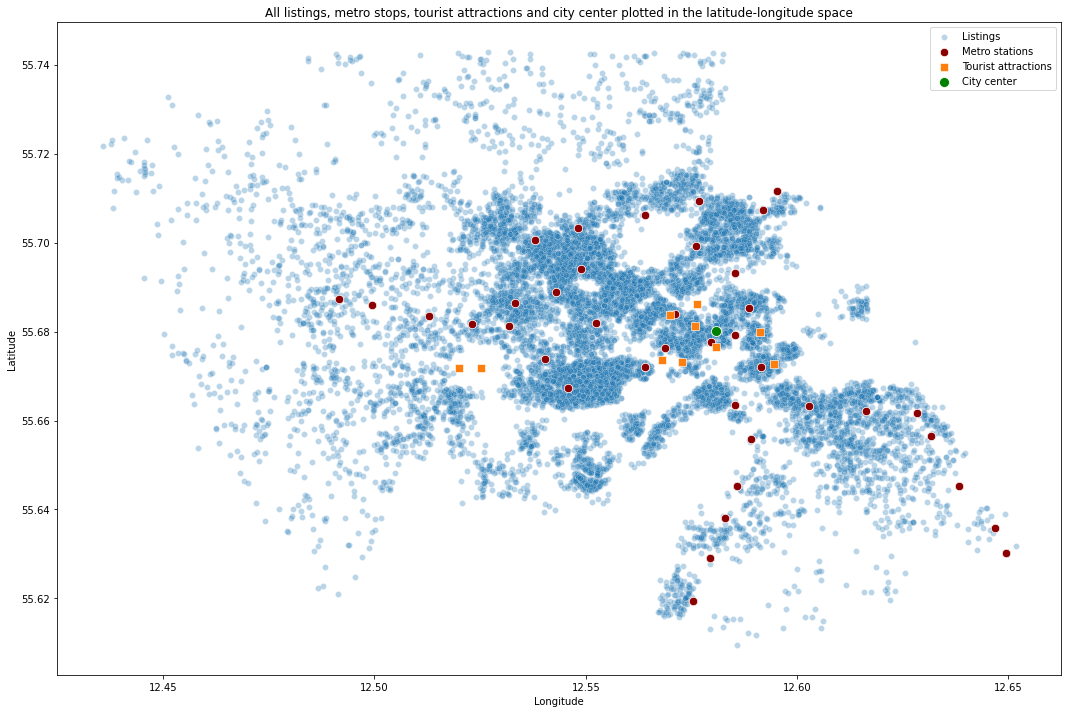

In [9]:
# df_indre_by needed locally for plotting with seaborn
df_indre_by = pd.DataFrame().from_dict(data={"City center": indre_by_loc}, orient='index', columns=["latitude", "longitude"])

# Display all metro stations, indre by and tourist attractions together with our listings
plt.figure(figsize=(18,12))
sns.scatterplot(data=df_listings, x="longitude", y="latitude", alpha=0.3)
sns.scatterplot(data=df_stops, x="longitude", y="latitude", color="darkred", s=70)
sns.scatterplot(data=df_tourist_attractions, x="longitude", y="latitude",marker="s", s=60)
sns.scatterplot(data=df_indre_by, x="longitude", y="latitude",color='green',marker="o", s=100)
plt.legend(["Listings", "Metro stations", "Tourist attractions", "City center"])
plt.title("All listings, metro stops, tourist attractions and city center plotted in the latitude-longitude space")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

As seen from the plot above, the majority of the listings have a metro stop quite close by, and the majority of the tourist attractions are located close to the city center. The former fact may be to our disadvantage, as a short distance to the city center implies a short distance to eight of the ten tourist attractions. Thus, these columns *may* contain more or less the same information, and will most likely be highly correlated accross all listings. 

Now: Display listings with colormap based on proximity to metro and city center, to check if the columns are consistent.

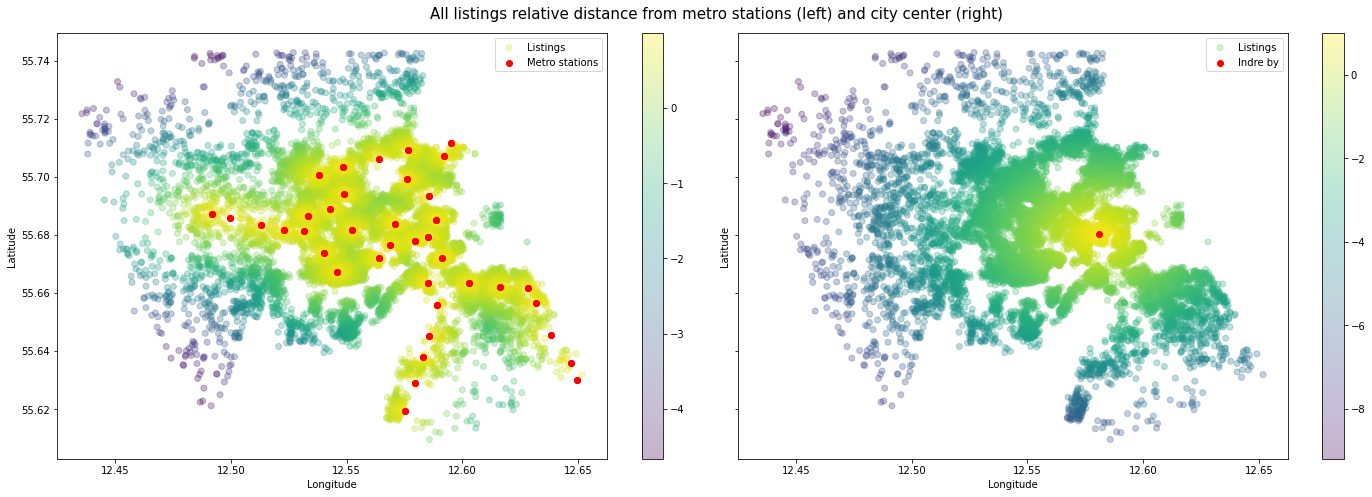

In [10]:
# Display all stations together with our listings
local_col_1 = 1 - df_listings["distance to metro"]

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True,figsize=(20,7))
sc1 = ax1.scatter(df_listings["longitude"], df_listings["latitude"], c=local_col_1, alpha=0.3)
ax1.scatter(df_stops["longitude"], df_stops["latitude"],color='#FF0000')
ax1.legend(["Listings", "Metro stations"])
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")

local_col_2 = 1 - df_listings["distance to indre by"]
sc2 = ax2.scatter(df_listings["longitude"], df_listings["latitude"], c=local_col_2, alpha=0.3)
ax2.scatter(indre_by_loc[1], indre_by_loc[0], color='#FF0000', )
ax2.legend(["Listings", "Indre by"])
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")

fig.suptitle("All listings relative distance from metro stations (left) and city center (right)", fontsize=15)
fig.colorbar(sc2)
fig.colorbar(sc1)
fig.tight_layout()
plt.show()

Looks ok.

To understand our new features, we should plot their distributions. The below plot contains a histogram of all the added features.

array([[<AxesSubplot: title={'center': 'distance to metro'}>,
        <AxesSubplot: title={'center': 'distance to indre by'}>,
        <AxesSubplot: title={'center': 'distance to Nyhavn'}>],
       [<AxesSubplot: title={'center': 'distance to Tivoli'}>,
        <AxesSubplot: title={'center': 'distance to Rosenborg slot'}>,
        <AxesSubplot: title={'center': 'distance to Frederiksberg slot'}>],
       [<AxesSubplot: title={'center': 'distance to Vor Frelsers kirke'}>,
        <AxesSubplot: title={'center': 'distance to Christiansborg slot'}>,
        <AxesSubplot: title={'center': 'distance to Torvehallerne'}>],
       [<AxesSubplot: title={'center': 'distance to Rundetårn'}>,
        <AxesSubplot: title={'center': 'distance to Glyptoteket'}>,
        <AxesSubplot: title={'center': 'distance to Københavns zoo'}>]],
      dtype=object)

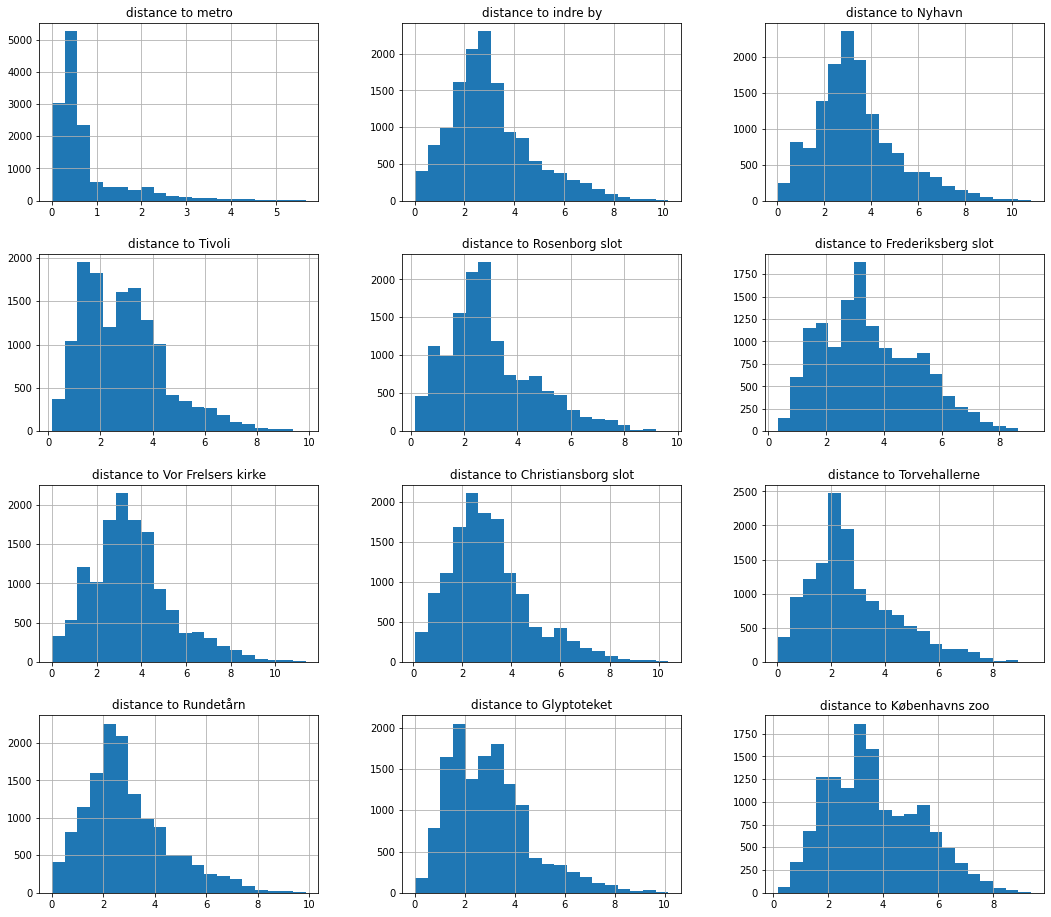

In [11]:
df_ = df_listings[['distance to metro', 'distance to indre by',
       'distance to Nyhavn', 'distance to Tivoli',
       'distance to Rosenborg slot', 'distance to Frederiksberg slot',
       'distance to Vor Frelsers kirke', 'distance to Christiansborg slot',
       'distance to Torvehallerne', 'distance to Rundetårn',
       'distance to Glyptoteket', 'distance to Københavns zoo']]
df_.hist(figsize=(18,16), bins=20)

The histograms shows a that most of the new columns are skewed towards small values, which is obvious from the heatmaps above. Frederiksberg slot and København zoo tends to be the two tourist attractions that lie furthest away from the listings, on average. Intuitively, this makes sense as these two are located furthest away from the city center, where the density of listings is high. Furthermore, the distance to metro-plot shows that most of the listings in Copenhagena are within 1 kilometer of a metro stop. In other words, the metro in copenhagen seems to be well distributed, given these airbnb-listings.

If two given tourist attractions are close to one another, it is obvious that for all listings, the distribution of the proximity from the listings to the tourist attraction will look quite similar for the two attractions. This is clearly the case above, which is why some of the distributions are very similar.

#### 1.5. Correlations
Check correlations between our new variables and the price of the listings

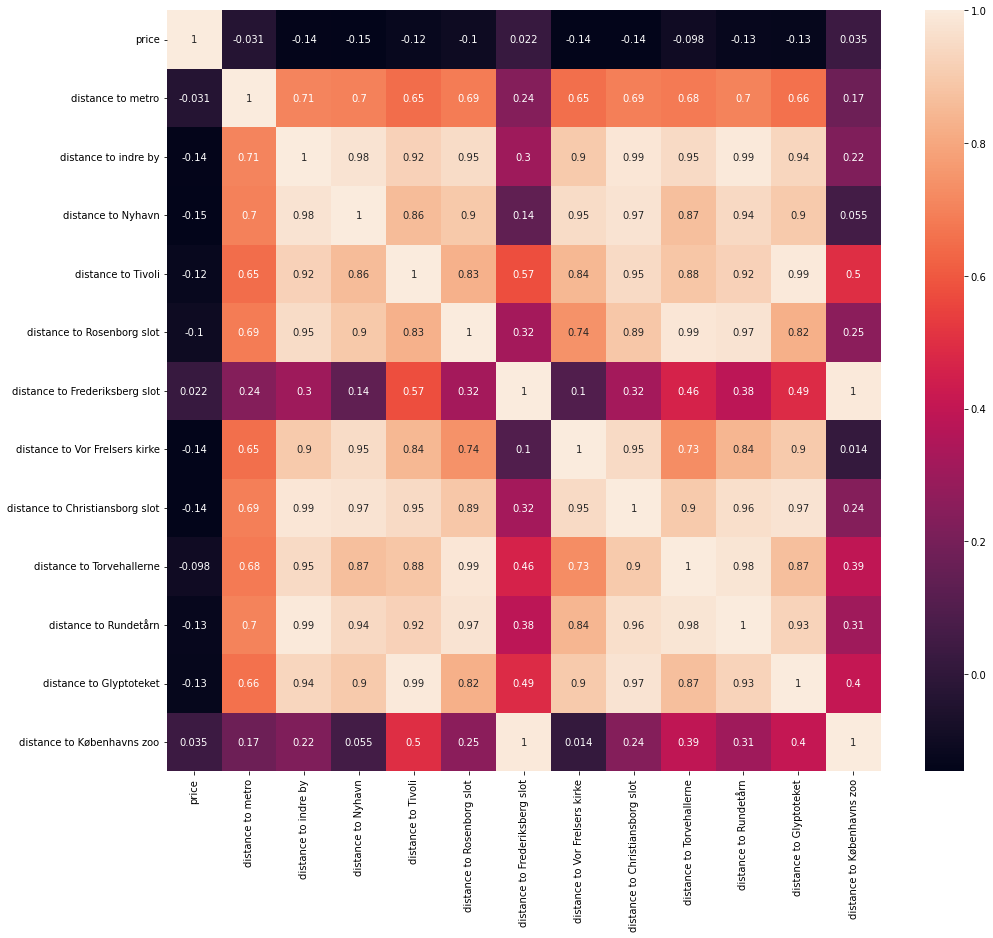

In [12]:
df_= df_listings[['price','distance to metro', 'distance to indre by',
       'distance to Nyhavn', 'distance to Tivoli',
       'distance to Rosenborg slot', 'distance to Frederiksberg slot',
       'distance to Vor Frelsers kirke', 'distance to Christiansborg slot',
       'distance to Torvehallerne', 'distance to Rundetårn',
       'distance to Glyptoteket', 'distance to Københavns zoo']]
plt.figure(figsize=(16,14))
sns.heatmap(df_.corr(), annot=True)
plt.show()

As one can see, our new variables does not correlate with the price of the listings, but they do have high correlations with each other. The only thing we can take from the correlation matrix above is that almost all tourist attractions except from København zoo and Frederiksberg slot, lies close to the city center (and therefore each other as well), which we knew from before. Also, the metro proximity correlates less with all the tourist attractions than city center proximity - this is expected as almost all tourist attractions are located near the city ceter, while the metro stops are more spread out across the whole city.

For comparison, we plot the correlation matrix for the 'old' variables once more.

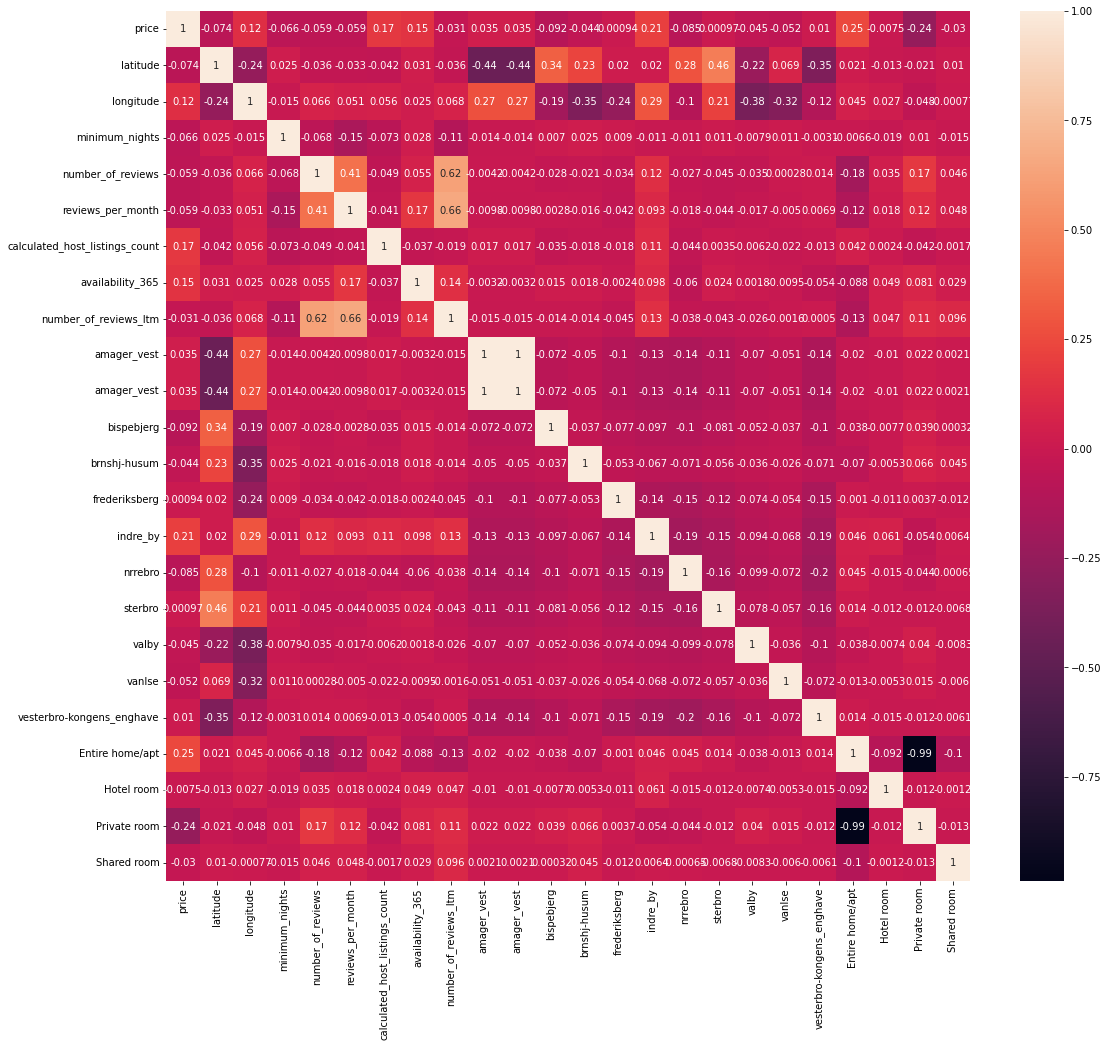

In [13]:
df_= df_listings[['price', 'latitude', 'longitude', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'amager_vest', 'bispebjerg',
       'brnshj-husum', 'frederiksberg', 'indre_by', 'nrrebro', 'sterbro',
       'valby', 'vanlse', 'vesterbro-kongens_enghave',
       'Entire home/apt', 'Hotel room', 'Private room', 'Shared room']]
plt.figure(figsize=(18,16))
sns.heatmap(df_.corr(), annot=True)
plt.show()

This also show no high correlations. However, the price correlate *more* with for example the "Entire home/apt", "availability_365" and "indre by"-column than it does with any of our new features. We can not base our whole analysis on the correlations between the variables, but this is a good indicator that it may be hard to predict the price of a given listing better than in part 1, solely based off our newly added features. However, we will quantify this in the classification part.

### Exploratory component part 2: Clustering and classification

#### 2.1: Classification with our new variables
Try classification to see if it is possible to perform better than in the classification part with just the new columns that describe proximities to center, metro and tourist attractions.<br/>
Classification methods are:
* Logistic Regression
* Support Vector Machine (SVM)
* Random Forest Classifier

Prepare training and testing set, normalize data and create binary target variable

In [14]:
# Create target variable
threshold = df_listings["price"].median()
y = [1 if y_i > threshold else 0 for y_i in df_listings["price"]]

X = df_listings.drop(columns=["id","price"], axis=1)

# Normalize X
normalize_cols = ['longitude', 'latitude', 'minimum_nights', 'number_of_reviews',
              'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 
              'number_of_reviews_ltm', 'distance to metro', 'distance to indre by',
              'distance to Nyhavn', 'distance to Tivoli',
              'distance to Rosenborg slot', 'distance to Frederiksberg slot',
              'distance to Vor Frelsers kirke', 'distance to Christiansborg slot',
              'distance to Torvehallerne', 'distance to Rundetårn',
              'distance to Glyptoteket', 'distance to Københavns zoo']

X_normalized = X.copy()
X_normalized[normalize_cols] = (X[normalize_cols] - X[normalize_cols].min()) / (X[normalize_cols].max() - X[normalize_cols].min())
X_normalized

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,amager_vest,bispebjerg,...,distance to Nyhavn,distance to Tivoli,distance to Rosenborg slot,distance to Frederiksberg slot,distance to Vor Frelsers kirke,distance to Christiansborg slot,distance to Torvehallerne,distance to Rundetårn,distance to Glyptoteket,distance to Københavns zoo
0,0.576938,0.517147,0.033898,0.241913,0.044963,0.000000,0.000000,0.008493,0,0,...,0.262193,0.182252,0.174214,0.206102,0.292336,0.223908,0.152629,0.188420,0.213287,0.238738
1,0.626904,0.651733,0.050847,0.082982,0.022898,0.000000,0.830137,0.016985,0,0,...,0.159943,0.212854,0.064581,0.417092,0.222127,0.175184,0.118130,0.132088,0.219621,0.443988
2,0.498987,0.646689,0.033898,0.421941,0.085762,0.011236,0.153425,0.014862,0,0,...,0.098591,0.038583,0.102732,0.325370,0.109979,0.027948,0.095244,0.058245,0.035442,0.362728
3,0.455548,0.552460,0.101695,0.033755,0.006661,0.000000,0.161644,0.004246,0,0,...,0.230948,0.077744,0.217072,0.177263,0.219060,0.164637,0.185588,0.180383,0.112659,0.221943
4,0.428327,0.553585,0.033898,0.026723,0.005412,0.000000,0.000000,0.004246,0,0,...,0.247936,0.100357,0.251401,0.188240,0.224475,0.182110,0.222305,0.209640,0.127993,0.231029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13703,0.925276,0.632665,0.220339,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,...,0.555913,0.661723,0.530483,0.805557,0.600880,0.602883,0.580183,0.581136,0.654360,0.799063
13704,0.437179,0.127805,0.033898,0.004219,0.042048,0.000000,0.000000,0.006369,0,0,...,0.752321,0.664074,0.759654,0.410132,0.726567,0.713304,0.733794,0.730633,0.678065,0.371348
13705,0.375314,0.180757,0.000000,0.004219,0.052873,0.000000,0.000000,0.006369,0,0,...,0.707141,0.608317,0.722742,0.357869,0.674246,0.663102,0.694285,0.687088,0.622794,0.324506
13706,0.911254,0.242158,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,...,0.796875,0.818832,0.767024,0.758045,0.819252,0.806970,0.780198,0.790016,0.821821,0.727405


Implement and evaluate our three classifiers

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, f1_score

# Create train and test splits
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=.33, random_state=123, shuffle=True)

reg = LogisticRegression()
svm = SVC()
rf = RandomForestClassifier()

# Fit all models and do predictions
y_pred_reg = reg.fit(X_train, y_train).predict(X_test)
y_pred_svm = svm.fit(X_train, y_train).predict(X_test)
y_pred_rf = rf.fit(X_train, y_train).predict(X_test)

Evaluate classifiers.<br/>
Display accuracy and f1-score and confusion matrix for all predictions

-----Logistic Regression-----
Logistic regression f1 score: 0.6750998668442076
Logistic regression accuracy score: 0.6763925729442971


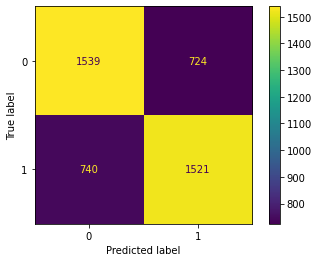

In [16]:
print("-----Logistic Regression-----")
print('Logistic regression f1 score:',f1_score(y_test,y_pred_reg))
print('Logistic regression accuracy score:',reg.score(X_test,y_test))
plot_confusion_matrix(reg, X_test, y_test)


-----SVM-----
SVM f1 score: 0.6766651962946625
SVM accuracy score: 0.6759504862953138


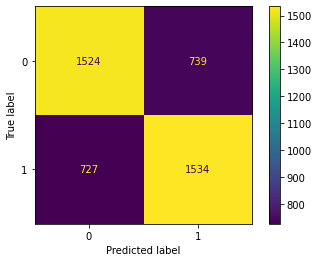

In [17]:
print("-----SVM-----")
print('SVM f1 score:',f1_score(y_test,y_pred_svm))
print('SVM accuracy score:',svm.score(X_test,y_test))
plot_confusion_matrix(svm, X_test, y_test)

-----Random Forest-----
Random Forest f1 score: 0.7020662075094425
Random Forest accuracy score: 0.7035809018567639


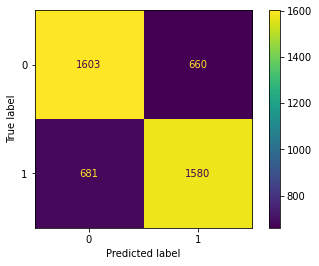

In [18]:
print("-----Random Forest-----")
print('Random Forest f1 score:',f1_score(y_test,y_pred_rf))
print('Random Forest accuracy score:',rf.score(X_test,y_test))
plot_confusion_matrix(rf, X_test, y_test)

#### 2.2. Model interpretation - what features are important for the price?
The performance of the classifiers are not very impressive. However, we will now see how the features differ in "importance" for the model when it makes predictions on the price. 

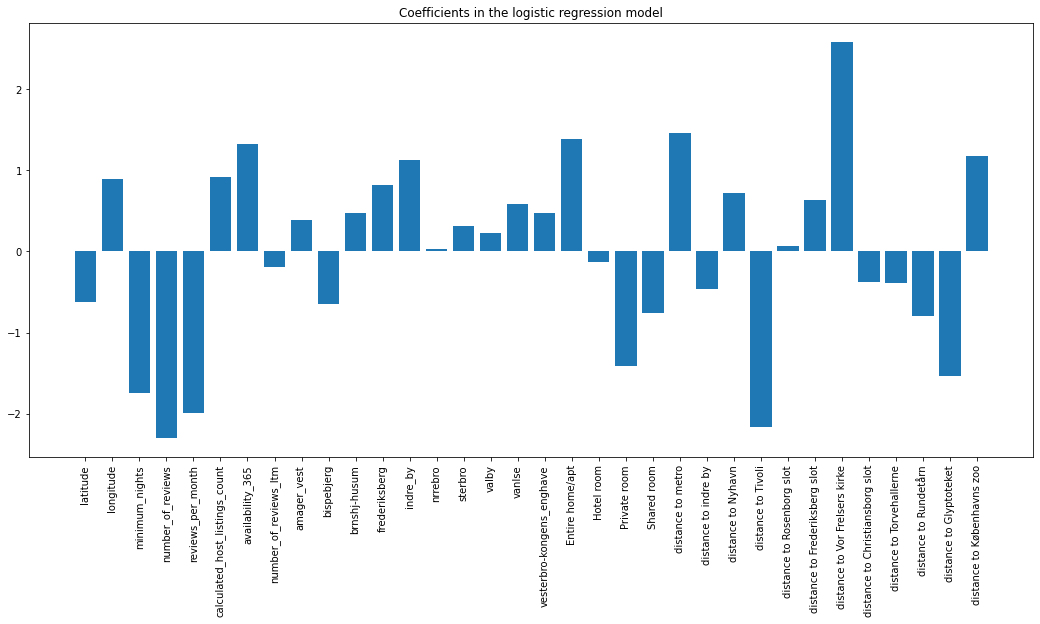

In [19]:
# Logistic regression and the feature importance:
importance = reg.coef_[0]

# plot feature importance
plt.figure(figsize=(18,8))
plt.bar([x for x in range(len(importance))], importance)
plt.xticks(ticks=range(X_normalized.shape[1]),labels=X_normalized.columns,rotation=90)
plt.title("Coefficients in the logistic regression model")
plt.show()

In the above, the positive scores indicate a feature that predicts class 1, whereas the negative scores indicate a feature that predicts class 0. I.e., if a feature's coefficient is high and positive, this indicates that the model suggests that, for a given listing, if that feature is high, the probability of the price being above the median (or y == 1) is also "high". Note that the lat- and long columns suggest that the price is higher towards the bottom right area of the map - this makes sense as the city center is located there.

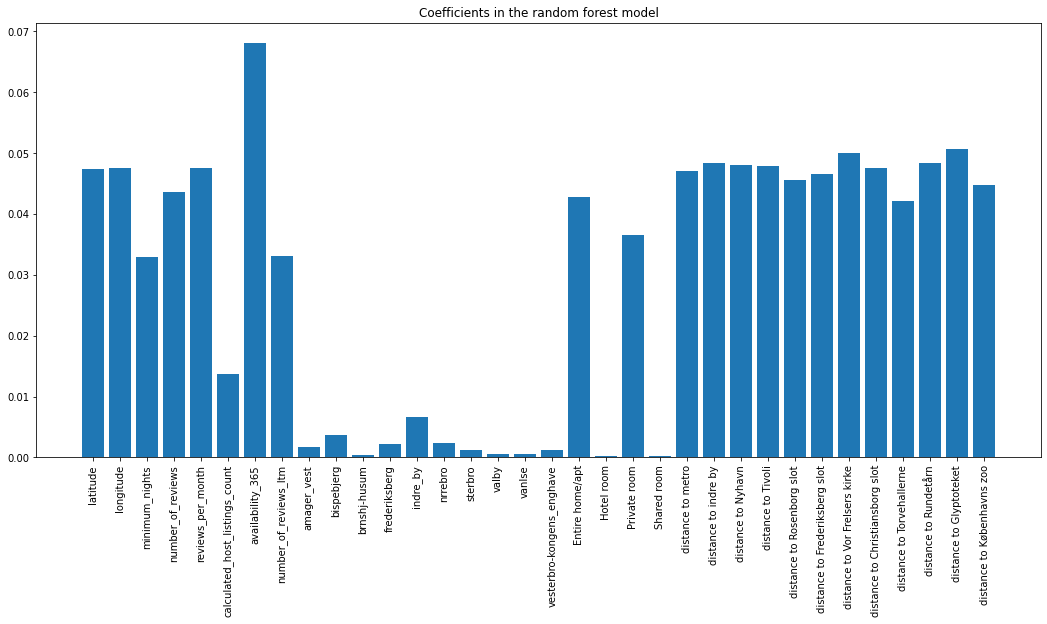

In [20]:
# Random forest and the feature importance:

importance = rf.feature_importances_

# plot feature importance
plt.figure(figsize=(18,8))
plt.bar([x for x in range(len(importance))], importance)
plt.xticks(ticks=range(X_normalized.shape[1]),labels=X_normalized.columns,rotation=90)
plt.title("Coefficients in the random forest model")
plt.show()

As seen from the plot above, the random forest classifier does not see the binary city-area features as important as the other features. It seems, from this model, as if the availability_365 feature is very important for determening the price of a given listing. This is also one of the features that has the highest correlation with the price. Also, it seems as if the model utilizes our added features, and give them all a reasonable amount of importance for determining the price of a listing.

#### 2.3: Clustering - Kmeans

Now try clustering to see how unsupervised learning might differentiate our data. We let k=9 be the number of clusters. We plot the 9 cluster centroids as line plots to see in what feature they differ from one another. We also project the clusters in the lat-lon space to see if they differ in the regions on the map. For the clustering-data, we have taken out the binary variables describing the area of the city a listing belongs to. This is done to avoid the clusters being artificially dependent on the area of the city, and not the other variables. 

In [21]:
from sklearn.cluster import KMeans

price_normalized = (df_listings["price"] - df_listings["price"].min())/(df_listings["price"].max() - df_listings["price"].min())
kmeans_data = X_normalized.copy()[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm',
       'distance to metro', 'distance to indre by', 'distance to Nyhavn',
       'distance to Tivoli', 'distance to Rosenborg slot',
       'distance to Frederiksberg slot', 'distance to Vor Frelsers kirke',
       'distance to Christiansborg slot', 'distance to Torvehallerne',
       'distance to Rundetårn', 'distance to Glyptoteket',
       'distance to Københavns zoo']] # Choose only the non-binary variables to prevent kmeans from clustering solely on area of city

# Add normalized price to clustering data
kmeans_data["price"] = price_normalized

kmeans = KMeans(n_clusters=9)
labels = kmeans.fit_predict(kmeans_data) 

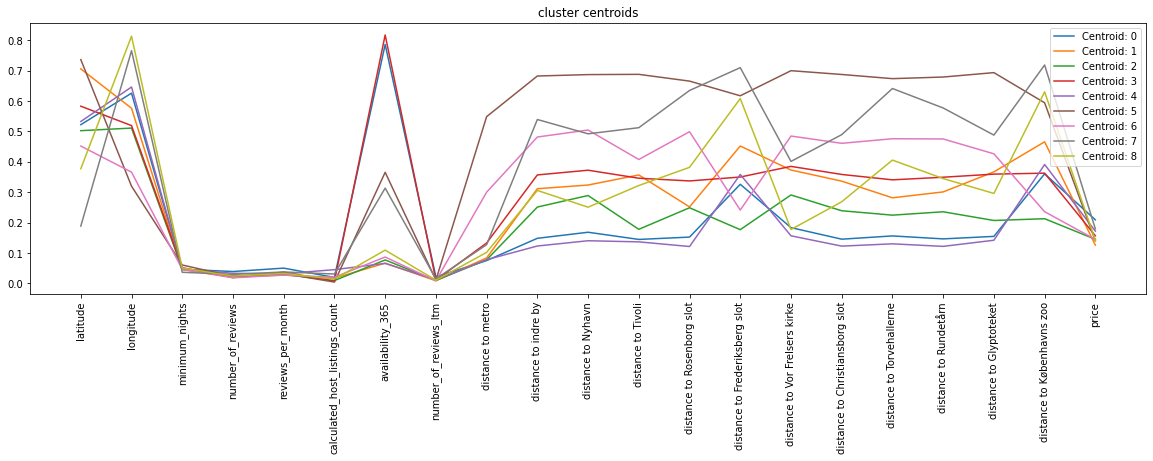

[Text(0.5, 1.0, 'All listings projected onto the lat-lon space, colored by what cluster the listing belongs to')]

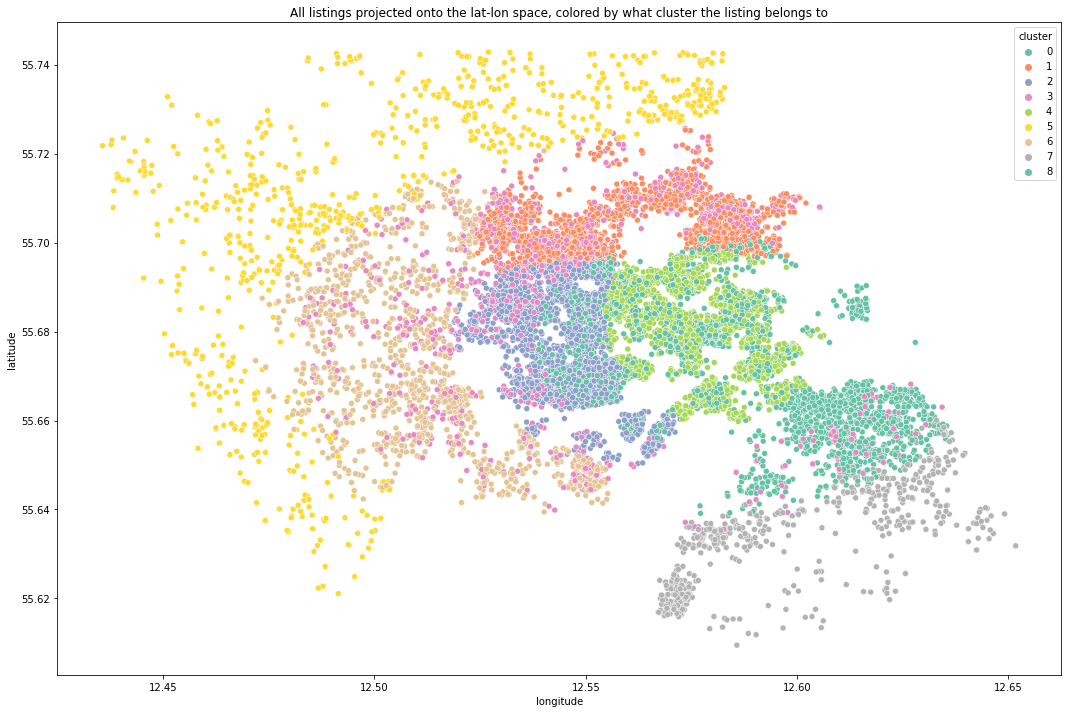

In [22]:
# Visualizing cluster centroids as lineplots:
centroids = kmeans.cluster_centers_
legends = []

plt.figure(figsize=(20,5))
for i, c in enumerate(centroids):
    plt.plot(c)
    legends.append(f"Centroid: {i}")
plt.legend(legends)
plt.xticks(ticks=range(len(centroids[0])),labels=kmeans_data.columns,rotation=90)
plt.title("cluster centroids")
plt.show()

# Visualize cluster centroids with colored scatter
X_normalized["cluster"] = labels
df_listings["cluster"] = labels
plt.figure(figsize=(18,12))
sns.scatterplot(data=df_listings, x="longitude", y="latitude", hue="cluster", palette="Set2").set(title="All listings projected onto the lat-lon space, colored by what cluster the listing belongs to")

From the plots, it seems as if our cluster centroids highly differ in latitude, longitude, availability_365, as well as all the distance_to_**x**-columns.

Display the above cluster-wise.

Text(0.5, 0.98, 'All cluster members projected onto lat-lon space')

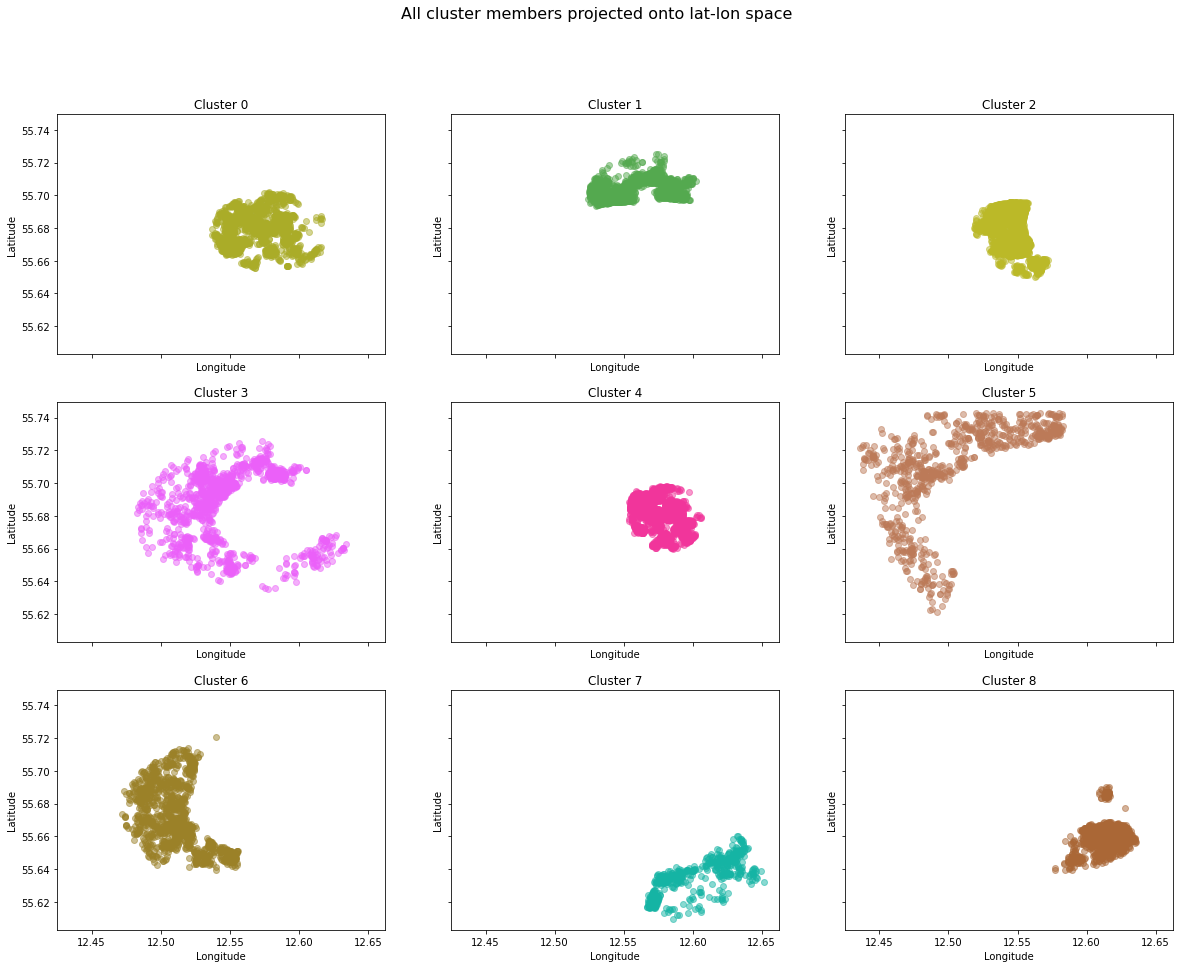

In [23]:
import random

# Random colors for plot
colors = []
for j in range(len(centroids)):
    r = lambda: random.randint(0,255)
    colors.append('#%02X%02X%02X' % (r(),r(),r()))


fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(20, 15))
for i, ax in zip(range(len(centroids)), axs.ravel()):
    data = df_listings.where(df_listings["cluster"] == i).dropna()
    ax.scatter(x=data["longitude"], y=data["latitude"], c=colors[i], alpha=0.5)
    ax.set_title(f"Cluster {i}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

fig.suptitle('All cluster members projected onto lat-lon space', fontsize=16)

As seen from the above, the clusters differ in latitude and longitude.

In [24]:
# Now, X contain a cluster row, lets see if this improves performace of classifiers when transformed to dummies
cluster = pd.get_dummies(X_normalized['cluster'], drop_first=True)
X_normalized = pd.merge(X_normalized, cluster, left_index=True, right_index=True)
X_normalized = X_normalized.drop('cluster', 1)

Again, do classification and evaluate performance.

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=.33, random_state=123, shuffle=True)

reg = LogisticRegression()
svm = SVC()
rf = RandomForestClassifier()

y_pred_reg = reg.fit(X_train, y_train).predict(X_test)
y_pred_svm = svm.fit(X_train, y_train).predict(X_test)
y_pred_rf = rf.fit(X_train, y_train).predict(X_test)

-----Logistic Regression w/ clusters-----
Logistic regression f1 score: 0.6890203813280736
Logistic regression accuracy score: 0.6863395225464191


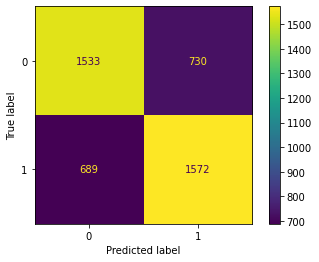

In [39]:
print("-----Logistic Regression w/ clusters-----")
print('Logistic regression f1 score:',f1_score(y_test,y_pred_reg))
print('Logistic regression accuracy score:',reg.score(X_test,y_test))
plot_confusion_matrix(reg, X_test, y_test)

-----SVM w/ clusters-----
SVM f1 score: 0.6824281150159746
SVM accuracy score: 0.6704244031830239


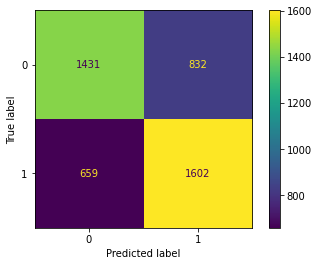

In [40]:
print("-----SVM w/ clusters-----")
print('SVM f1 score:',f1_score(y_test,y_pred_svm))
print('SVM accuracy score:',svm.score(X_test,y_test))
plot_confusion_matrix(svm, X_test, y_test)

-----Random Forest w/ clusters-----
Random Forest f1 score: 0.7013857845328565
Random Forest accuracy score: 0.7046861184792219


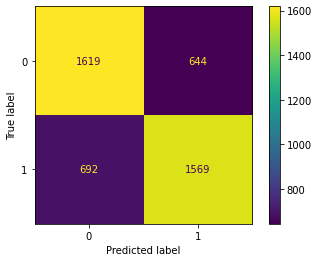

In [41]:
print("-----Random Forest w/ clusters-----")
print('Random Forest f1 score:',f1_score(y_test,y_pred_rf))
print('Random Forest accuracy score:',rf.score(X_test,y_test))
plot_confusion_matrix(rf, X_test, y_test)

Not any better with clusters as labels where the clusters are based on all the columns of df_listings.

#### 3. Conclusion and further work

When inserting new columns based on the proximity to metro stops, tourist attractions and the city center, the binary prediction with the three given models did not improve significantly. In the below table the scores of the binary classification with the original and our added features is given.

<center>

| **Classification model**         | **f1-score** | **Accuracy score** |
|----------------------------------|--------------|--------------------|
| LogReg org. features             |     0.681    |        0.671       |
| SVM org. features                |     0.705    |        0.593       |
| RF org. features                 |     0.712    |        0.711       |
| LogReg + new features            |     0.675    |        0.676       |
| SVM + new features               |     0.677    |        0.676       |
| RF + new features                |     0.702    |        0.704       |
| LogReg + new features + clusters |     0.690    |        0.686       |
| SVM + new features + clusters    |     0.682    |        0.670       |
| RF + new features + clusters     |     0.701    |        0.705       | 

</center>

The poor accuracy and f1-score might be due to several factors. One being that the price of a given airbnb listings is not as dependent on the locality of the home as we initially thought. A listing closer to the center (and thus the tourist attractions and metro stops) do seem to be a bit more expensive, but we also find listings in the same area that does not follow that price trend - which in turn makes it hard to predict price based on locality alone. Furthermore, our added features does seem to contain information that already lies in the data, in addition to the fact that the features are highly correlated with each other. In retrospect, we should have chosen our added features more carefully so that the correlation between them would be lower (and thus more information added). 

Furthermore, clustering the data and using the clusters as binary features did not improve classification scores significantly. However, the clustering did reveal some interesting patterns in the data that might be used in further work.

To predict the price more accurately in the future, we would definitely include some data on the actual airbnb (square feet, number of stars, floors, etc.). One could also look at data from other cities and try to use informations from the columns that are similar accross cities (number of reviews, availability, etc.).

#### Individual contributions

The table below describes the contributions from each group member. 

<center>

| Student | Part 1 | Part 2 |
|---------|--------|--------|
| Håvard Sætenes (s223321)  | 50%|0%|
| Ole Hartvig Nissen Johannson (s221450) |50%|0%|
| Eirik Runde Barlaug (s221409) |0%|50%|
| Simon Cabral Iversen (s223286) |0%|50%|

</center>

#### Word count
From: https://stackoverflow.com/questions/71194571/word-count-of-markdown-cells-in-jupyter-notebook

In [48]:
import json

with open('part2.ipynb', encoding='utf-8') as json_file:
    data = json.load(json_file)

In [49]:
wordCount = 0
for each in data['cells']:
    cellType = each['cell_type']
    if cellType == "markdown":
        content = each['source']
        for line in content:
            temp = [word for word in line.split() if "#" not in word] # we might need to filter for more markdown keywords here
            wordCount = wordCount + len(temp)
            
print(wordCount)

1777
